# Deep Learning with Python 
# 3.1 - IMDb Dataset Experiments

## Data Preprocessing

In [34]:
# Importing the dataset
from tensorflow import keras
from tensorflow.keras.datasets import imdb

# Setting up `numpy` to read in pickle files
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [35]:
# One hot encoding of the reviews into sparse 10_000 dimensional vectors
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

In [36]:
# Confirming that train and test data has been encoded properly
print(train_data.shape)
print(test_data.shape)
print(train_data[0])

(25000, 10000)
(25000, 10000)
[0. 1. 1. ... 0. 0. 0.]


In [37]:
# Vectorizing the output labels as well
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [38]:
# Extracting validation set from the training set
x_val = train_data[:10000]
y_val = train_labels[:10000]

x_train = train_data[10000:]
y_train = train_labels[10000:]

### Investigation 1 - One Hidden Layer
One hidden layer means the input layer will be followed directly by the output layer.

In [113]:
from tensorflow.keras import models, layers

In [114]:
# Instantiating a model with only one layer
model = models.Sequential()
model.add(layers.Dense(units=16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(units=1, activation='sigmoid'))

In [115]:
# Compiling model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [116]:
# Train model for 4 epochs with a batch size of 512
one_hidden_layer = model.fit(x=x_train, 
                             y=y_train, 
                             batch_size=512, 
                             epochs=4, 
                             validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 446us/sample - loss: 0.5094 - acc: 0.7951 - val_loss: 0.4037 - val_acc: 0.8621
Epoch 2/4
15000/15000 [==============================] - 5s 347us/sample - loss: 0.3288 - acc: 0.9014 - val_loss: 0.3525 - val_acc: 0.8612
Epoch 3/4
15000/15000 [==============================] - 5s 353us/sample - loss: 0.2556 - acc: 0.9212 - val_loss: 0.3171 - val_acc: 0.8708
Epoch 4/4
15000/15000 [==============================] - 6s 370us/sample - loss: 0.2097 - acc: 0.9369 - val_loss: 0.2805 - val_acc: 0.8891


In [45]:
# Importing `matplotlib` for visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
# Defining a function that can be reused to plot validation and training losses
def visualize_training_results(history_obj, title_str='Model Results'):
    history = history_obj.history
    loss = history['loss']
    val_acc = history['val_acc']
    val_loss = history['val_loss']
    acc = history['acc']
    epochs = range(1, len(acc) + 1)
    
    # Loss figure
    plt.figure()
    plt.plot(epochs, val_loss, 'bo', label='Validation Loss')
    plt.plot(epochs, loss, 'b-', label='Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title(title_str + ' - Loss');
    plt.grid(True); plt.legend(); plt.show()
    
    # Accuracy Figure
    plt.figure(); plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
    plt.plot(epochs, acc, 'b-', label='Accuracy');
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title(title_str + ' - Accuracy')
    plt.grid(True); plt.legend(); plt.show()

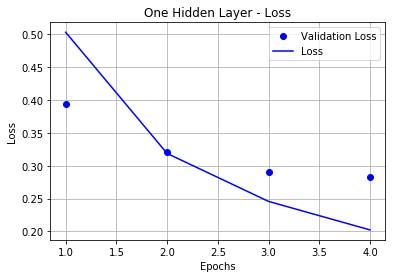

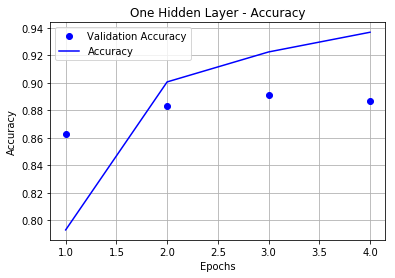

In [47]:
visualize_training_results(one_hidden_layer, title_str='One Hidden Layer')

### Investigation 2 - Three Hidden Layers

In [53]:
def makeSequentialDenseModel(model_dict):
    assert len(model_dict.items()) > 0
    
    model = models.Sequential()
    
    # For the first layer in the dictionary
    model.add(layers.Dense(model_dict['first']['units'], 
                           activation=model_dict['first']['activation'], 
                           input_shape=model_dict['first']['input']))
    
    # Then parse the `hidden` property and add each layer to the model
    for layer in model_dict['hidden']:
        model.add(layers.Dense(units=layer['units'], 
                              activation=layer['activation']))
    
    # Then add the output 
    model.add(layers.Dense(model_dict['output']['units'], model_dict['output']['activation']))
    
    # Return the final model
    return model
    

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 451us/sample - loss: 0.4145 - acc: 0.8258 - val_loss: 0.2856 - val_acc: 0.8873
Epoch 2/4
15000/15000 [==============================] - 6s 394us/sample - loss: 0.2192 - acc: 0.9175 - val_loss: 0.3072 - val_acc: 0.8768
Epoch 3/4
15000/15000 [==============================] - 6s 389us/sample - loss: 0.1535 - acc: 0.9427 - val_loss: 0.4994 - val_acc: 0.8317
Epoch 4/4
15000/15000 [==============================] - 6s 407us/sample - loss: 0.1151 - acc: 0.9600 - val_loss: 0.3463 - val_acc: 0.8805


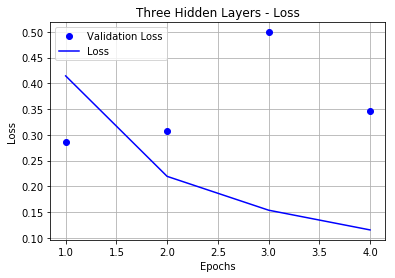

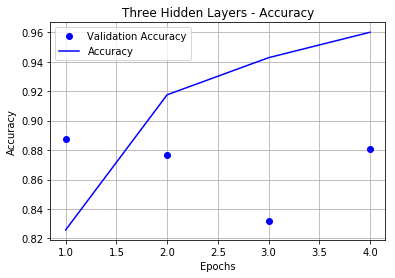

In [71]:
# Making a dictionary for a model with 3 hidden layers
threeHiddenLayersDict = {
        'first': {'activation':'relu', 'units': 16, 'input': (10000,)},
        'hidden': [
            {'activation':'relu', 'units': 16},
            {'activation':'relu', 'units': 16}
        ], 
        'output': {'activation': 'sigmoid', 'units': 1}
}

# Getting the model with a function call
threeHiddenLayersModel = makeSequentialDenseModel(threeHiddenLayersDict)

# Compile the model
threeHiddenLayersModel.compile(optimizer='rmsprop', 
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

# Train it for 4 epochs
threeHiddenLayersHistory = threeHiddenLayersModel.fit(x=x_train, y=y_train, batch_size=128, epochs=4,
                          validation_data=(x_val, y_val))

# Visualize Results
visualize_training_results(threeHiddenLayersHistory, title_str='Three Hidden Layers')

### Investigation 3 - 2 Layers, 32 Units

In [78]:
# Define model dictionary
twoLayer32UnitsDict = {
        'first': {'activation':'relu', 'units': 32, 'input': (10000,)},
        'hidden': [
            {'activation':'relu', 'units': 32},
        ], 
        'output': {'activation': 'sigmoid', 'units': 1}
}
twoLayer32UnitsModel = makeSequentialDenseModel(twoLayer32UnitsDict)
twoLayer32UnitsModel.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                            metrics=['accuracy'])

In [79]:
twoLayer32UnitsHistory = twoLayer32UnitsModel.fit(x_train, y_train, batch_size=512, epochs=4,
                                                 validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 464us/sample - loss: 0.4931 - acc: 0.7701 - val_loss: 0.3464 - val_acc: 0.8788
Epoch 2/4
15000/15000 [==============================] - 6s 376us/sample - loss: 0.2715 - acc: 0.9079 - val_loss: 0.2832 - val_acc: 0.8906
Epoch 3/4
15000/15000 [==============================] - 6s 387us/sample - loss: 0.1982 - acc: 0.9301 - val_loss: 0.2721 - val_acc: 0.8920
Epoch 4/4
15000/15000 [==============================] - 6s 386us/sample - loss: 0.1539 - acc: 0.9479 - val_loss: 0.2867 - val_acc: 0.8871


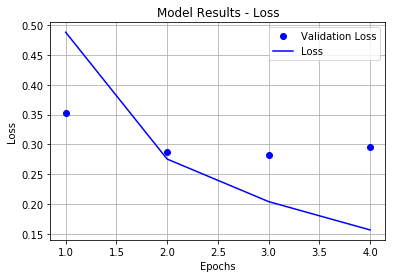

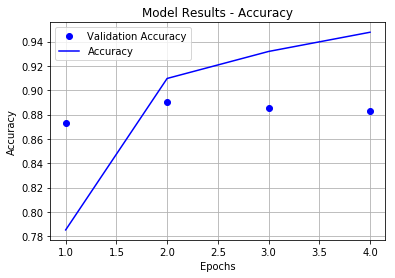

In [77]:
visualize_training_results(twoLayer32UnitsHistory)

### Investigation 4 - 2 Layers, 64 Units

In [80]:
# Define model dictionary
twoLayer64UnitsDict = {
        'first': {'activation':'relu', 'units': 64, 'input': (10000,)},
        'hidden': [
            {'activation':'relu', 'units': 64},
        ], 
        'output': {'activation': 'sigmoid', 'units': 1}
}
twoLayer64UnitsModel = makeSequentialDenseModel(twoLayer32UnitsDict)
twoLayer64UnitsModel.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                            metrics=['accuracy'])

In [81]:
twoLayer64UnitsHistory = twoLayer64UnitsModel.fit(x_train, y_train, batch_size=512, epochs=4, 
                                                 validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 6s 428us/sample - loss: 0.4920 - acc: 0.7775 - val_loss: 0.3407 - val_acc: 0.8775
Epoch 2/4
15000/15000 [==============================] - 6s 428us/sample - loss: 0.2738 - acc: 0.9029 - val_loss: 0.3231 - val_acc: 0.8679
Epoch 3/4
15000/15000 [==============================] - 6s 396us/sample - loss: 0.1947 - acc: 0.9316 - val_loss: 0.2762 - val_acc: 0.8889
Epoch 4/4
15000/15000 [==============================] - 6s 391us/sample - loss: 0.1495 - acc: 0.9469 - val_loss: 0.2889 - val_acc: 0.8877


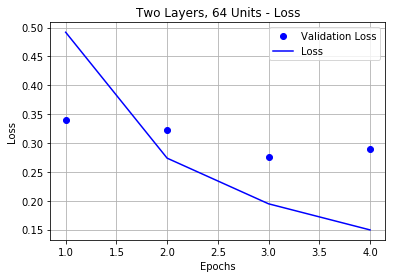

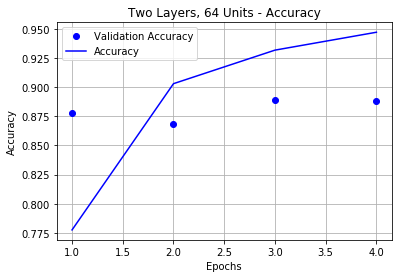

In [83]:
visualize_training_results(twoLayer64UnitsHistory, 'Two Layers, 64 Units')

### Investigation 5 - `mse` Loss Function

In [84]:
# Define model dictionary
mseTestModelDict = {
        'first': {'activation':'relu', 'units': 16, 'input': (10000,)},
        'hidden': [
            {'activation':'relu', 'units': 16},
        ], 
        'output': {'activation': 'sigmoid', 'units': 1}
}
mseTestModel = makeSequentialDenseModel(mseTestModelDict)

In [85]:
mseTestModel.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


In [86]:
mseTestModelHistory = mseTestModel.fit(x_train, y_train, batch_size=512, epochs=4, 
                                       validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 6s 416us/sample - loss: 0.1723 - acc: 0.7875 - val_loss: 0.1203 - val_acc: 0.8700
Epoch 2/4
15000/15000 [==============================] - 5s 351us/sample - loss: 0.0918 - acc: 0.9046 - val_loss: 0.0929 - val_acc: 0.8891
Epoch 3/4
15000/15000 [==============================] - 5s 354us/sample - loss: 0.0646 - acc: 0.9321 - val_loss: 0.0970 - val_acc: 0.8673
Epoch 4/4
15000/15000 [==============================] - 5s 348us/sample - loss: 0.0514 - acc: 0.9455 - val_loss: 0.0839 - val_acc: 0.8886


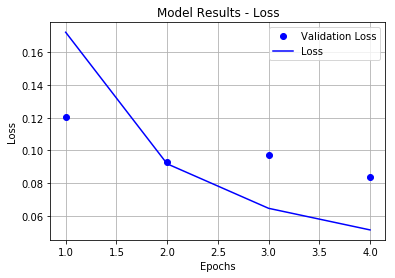

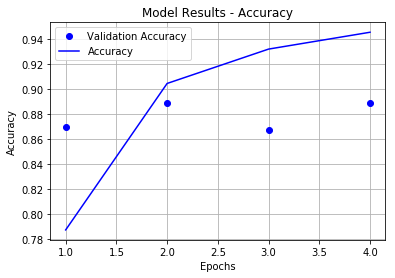

In [87]:
visualize_training_results(mseTestModelHistory)

### Investigation 6 - `tanh` Activation Function

In [88]:
tanhTestModelDict = {
        'first': {'activation':'tanh', 'units': 16, 'input': (10000,)},
        'hidden': [
            {'activation':'tanh', 'units': 16},
        ], 
        'output': {'activation': 'sigmoid', 'units': 1}
}

tanhTestModel = makeSequentialDenseModel(tanhTestModelDict)

In [89]:
tanhTestModel.compile(optimizer='rmsprop', metrics=['accuracy'], loss='binary_crossentropy')

In [90]:
tanhModelHistory = tanhTestModel.fit(x_train, y_train, batch_size=512, epochs=4, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 6s 423us/sample - loss: 0.4662 - acc: 0.7945 - val_loss: 0.3426 - val_acc: 0.8730
Epoch 2/4
15000/15000 [==============================] - 5s 348us/sample - loss: 0.2641 - acc: 0.9083 - val_loss: 0.3023 - val_acc: 0.8770
Epoch 3/4
15000/15000 [==============================] - 5s 346us/sample - loss: 0.1878 - acc: 0.9339 - val_loss: 0.2823 - val_acc: 0.8867
Epoch 4/4
15000/15000 [==============================] - 5s 347us/sample - loss: 0.1395 - acc: 0.9549 - val_loss: 0.2943 - val_acc: 0.8833


## Summarizing Results

In [91]:
# Training and testing base case - two hidden layers, 16 units, relu activation
baseModel = models.Sequential()
baseModel.add(layers.Dense(units=16, activation='relu', input_sbhape=(10000,)))
baseModel.add(layers.Dense(units=16, activation='relu'))
baseModel.add(layers.Dense(units=1, activation='sigmoid'))

In [93]:
baseModel.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [95]:
baseModel.fit(x_train, y_train, batch_size=512, epochs=4, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 6s 377us/sample - loss: 0.1434 - acc: 0.9536 - val_loss: 0.2967 - val_acc: 0.8812
Epoch 2/4
15000/15000 [==============================] - 5s 358us/sample - loss: 0.1216 - acc: 0.9614 - val_loss: 0.2988 - val_acc: 0.8836
Epoch 3/4
15000/15000 [==============================] - 6s 402us/sample - loss: 0.0993 - acc: 0.9698 - val_loss: 0.3074 - val_acc: 0.8839
Epoch 4/4
15000/15000 [==============================] - 6s 419us/sample - loss: 0.0824 - acc: 0.9770 - val_loss: 0.3291 - val_acc: 0.8812


In [117]:
# Dictionary of all models 
models_tested = {
    'BASE CASE: Two Hidden Layers': baseModel, 
    'One Hidden Layer': model,
    'Three Hidden Layer': threeHiddenLayersModel,
    '2 Layers, 32 Units': twoLayer32UnitsModel,
    '2 Layers, 64 Units': twoLayer64UnitsModel, 
    'MSE Model': mseTestModel, 
    'tanh Model': tanhTestModel
}

# For each model, predict on the test set
for (modelName, model) in models_tested.items():
    print(modelName.upper())
    model.evaluate(test_data, y_test)

BASE CASE: TWO HIDDEN LAYERS
25000/25000 [==============================] - 7s 284us/sample - loss: 0.3583 - acc: 0.8702
ONE HIDDEN LAYER
25000/25000 [==============================] - 7s 269us/sample - loss: 0.2989 - acc: 0.8822
THREE HIDDEN LAYER
25000/25000 [==============================] - 7s 278us/sample - loss: 0.3816 - acc: 0.8677
2 LAYERS, 32 UNITS
25000/25000 [==============================] - 7s 289us/sample - loss: 0.3122 - acc: 0.8766
2 LAYERS, 64 UNITS
25000/25000 [==============================] - 8s 314us/sample - loss: 0.3086 - acc: 0.8782
MSE MODEL
25000/25000 [==============================] - 7s 265us/sample - loss: 0.0892 - acc: 0.8811
TANH MODEL
25000/25000 [==============================] - 7s 268us/sample - loss: 0.3237 - acc: 0.8698


## Interpretation of Results
Based on these experimental results
- All models seem to have roughly the same acccuracy. 
- One hidden layer seems to have the highest accuracy and lowest loss.
- Three hidden layer model seems to have the lowest accuracy and highest loss, followed closely by the tanh model.